# Access this notebook on kaggle at <a href='https://www.kaggle.com/code/sadguava/hr-net-cityscapes'>this link</a>

## Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Conv2D, Activation, Add, Conv2DTranspose
from keras.applications.vgg16 import VGG16
import tensorflow.keras.backend as K
%matplotlib inline


## Read the Datasets

In [2]:
img = glob.glob('../input/cityscapes/Cityspaces/images/train/*/*.png') # tf.io.glob.glob
label = glob.glob('../input/cityscapes/Cityspaces/gtFine/train/*/*_gtFine_labelIds.png')
img_names = [path.split('/train/')[1].split('_leftImg8bit.png')[0] for path in img]
label = ['../input/cityscapes/Cityspaces/gtFine/train/' + name + '_gtFine_labelIds.png' for name in img_names]

len(img)

2975

**Pre-Shuffle the Data so as to Reduce the Buffer Size (for smaller-Size CPU & GPU)**

In [3]:
index = np.random.permutation(2975)
img = np.array(img)[index]
label = np.array(label)[index]

img[:5], label[:5]

(array(['../input/cityscapes/Cityspaces/images/train/darmstadt/darmstadt_000009_000019_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/tubingen/tubingen_000101_000019_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/hanover/hanover_000000_056457_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/hanover/hanover_000000_043550_leftImg8bit.png',
        '../input/cityscapes/Cityspaces/images/train/bremen/bremen_000008_000019_leftImg8bit.png'],
       dtype='<U105'),
 array(['../input/cityscapes/Cityspaces/gtFine/train/darmstadt/darmstadt_000009_000019_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/tubingen/tubingen_000101_000019_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_056457_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/gtFine/train/hanover/hanover_000000_043550_gtFine_labelIds.png',
        '../input/cityscapes/Cityspaces/g

In [4]:
val_img = glob.glob('../input/cityscapes/Cityspaces/images/val/*/*.png')
val_label = glob.glob('../input/cityscapes/Cityspaces/gtFine/val/*/*_gtFine_labelIds.png')
img_names = [path.split('/val/')[1].split('_leftImg8bit.png')[0] for path in val_img]
val_label = ['../input/cityscapes/Cityspaces/gtFine/val/' + name + '_gtFine_labelIds.png' for name in img_names]

len(val_img), len(val_label)

(500, 500)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((img, label))
val_ds = tf.data.Dataset.from_tensor_slices((val_img, val_label))

In [6]:
def read_png(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=3)
    return img
    
def read_png_label(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_png(img, channels=1)
    return img

## Data Augmentation


In [7]:
width=height=128

def rand_crop(img, label):
    concat_img = tf.concat([img, label], axis=-1)
    concat_img = tf.image.resize(concat_img, [150,150], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    concat_img = tf.image.random_crop(concat_img, [width,height, 4])
    return concat_img[:, :, :3], concat_img[:, :, 3:]

def norm(img, label):
    img = tf.cast(img, tf.float32)/127.5-1
    label = tf.cast(label, tf.int32)
    return img, label

In [8]:
def load_img_train(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img, label = rand_crop(img, label)
    
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        label = tf.image.flip_left_right(label)
    return norm(img, label)

def load_img_val(img, label):
    img = read_png(img)
    label = read_png_label(label)
    
    img = tf.image.resize(img, [width,height])
    label = tf.image.resize(label, [width,height])
    return norm(img, label)

In [9]:
BATCH_SIZE = 16
BUFFER_SIZE = 300
steps_per_epoch = 2975 // BATCH_SIZE
validation_steps = 500 // BATCH_SIZE
auto = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(load_img_train, num_parallel_calls=auto)
val_ds = val_ds.map(load_img_val, num_parallel_calls=auto)

24


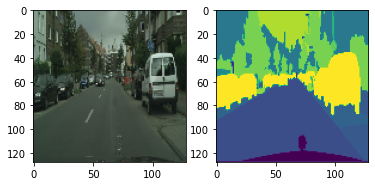

In [10]:
for img, label in val_ds.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow((img + 1)/2)
    plt.subplot(1, 2, 2) 
    print(len(np.unique(label)))
    plt.imshow(np.squeeze(label))
    
    


In [11]:
train_ds = train_ds.cache().repeat().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(auto)
val_ds = val_ds.cache().batch(BATCH_SIZE)

## Define the Model

In [12]:
!pip install -q git+https://github.com/tensorflow/examples.git
from tensorflow_examples.models.pix2pix import pix2pix
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_12_expand_relu'
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

base_model.summary()

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (Ba

In [13]:
def bottle_neck(inputs):
  res = inputs
  x = layers.Conv2D(64,kernel_size=1,padding='same')(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)

  x2 = layers.Conv2D(64,kernel_size=3,padding='same')(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  x3 = layers.Conv2D(128,kernel_size=1,padding='same')(x2)
  x3 = layers.BatchNormalization()(x3)
  x3 = tf.keras.activations.relu(x3)
  return x3 

def basic_block(inputs,num_channels,stride,padding):
  res = inputs

  x = layers.Conv2D(num_channels,kernel_size=3,strides=stride,padding = padding)(inputs)
  x = layers.BatchNormalization()(x)
  x = tf.keras.activations.relu(x)
  
  x2 = layers.Conv2D(num_channels,kernel_size=3,strides=1,padding = padding)(x)
  x2 = layers.BatchNormalization()(x2)
  x2 = tf.keras.activations.relu(x2)

  return x2

In [14]:
def create_model():
    inputs = tf.keras.layers.Input(shape=(width,height, 3))
    
    skips = down_stack(inputs)
    skip1=layers.UpSampling2D((2,2))(skips[0])
    
    skip21=skips[0]
    skip22=layers.UpSampling2D((2,2))(skips[1])
    
    skip31=skips[1]
    skip32=layers.UpSampling2D((2,2))(skips[2])
    skip33=layers.UpSampling2D((4,4))(skips[3])
    skip3=tf.keras.layers.Concatenate(axis=-1)([skip31,skip32 , skip33])

    
    

    x1 = bottle_neck(skip1)
    x1 = bottle_neck(x1)
    print("x1 = " , x1.shape)

    x21 = basic_block(x1,x1.shape[3],1,'same')
    x21 = basic_block(x21,x21.shape[3],1,'same')
    print("x21 = ",x21.shape)

    x22 = basic_block(x1,x1.shape[3]*2,2,'same')
    x22=tf.keras.layers.Concatenate(axis=-1)([x22,skip21 , skip22])
    x22 = basic_block(x22,x1.shape[3]*2,1,'same')
    print("x22 = ",x22.shape)


    x31 = layers.UpSampling2D((2,2))(x22)
    x31 = layers.Conv2D(x21.shape[3], (1,1) , strides =1 , padding = "same")(x31)
    x31 = tf.keras.layers.Add()([x21,x31])
    print("x31 = " , x31.shape)
    x31 = basic_block(x31,x31.shape[3],1,'same')
    print("x31 = " , x31.shape)
    x31 = basic_block(x31,x31.shape[3],1,'same')
    print("x31 = " , x31.shape)

    x32_1 = basic_block(x21 , x21.shape[3]*2 , 2 , 'same')
    x32_2= layers.Conv2D(x22.shape[3], (1,1) , strides =1 , padding = "same")(x22)
    x32 =tf.keras.layers.Add()([x32_1,x32_2])
    print("x32 = " , x32.shape)
    x32 = basic_block(x32,x32.shape[3],1,'same')
    print("x32 = " , x32.shape)
    x32 = basic_block(x32,x32.shape[3],1,'same')
    print("x32 = " , x32.shape)

    x33_1 = basic_block(x21 , x21.shape[3]*4 , 4 , 'same')
    x33_2 = basic_block(x22 , x22.shape[3]*2 , 2 , 'same')
    x33 = tf.keras.layers.Add()([x33_1,x33_2])
    x33= tf.keras.layers.Concatenate(axis=-1)([x33 , skip3])

    print("x33 = ", x33.shape)
    x33 = basic_block(x33,x22.shape[3]*2,1,'same')
    print("x33 = ", x33.shape)
    x33 = basic_block(x33,x33.shape[3],1,'same')
    print("x33 = ", x33.shape)

    x41_2 =  layers.UpSampling2D((2,2))(x32)
    x41_2 = layers.Conv2D(x31.shape[3], (1,1) , strides =1 , padding = "same")(x41_2)
    x41_3 = layers.UpSampling2D((4,4))(x33)
    x41_3= layers.Conv2D(x31.shape[3], (1,1) , strides =1 , padding = "same")(x41_3)

    output = tf.keras.layers.Concatenate(axis=-1)([x31,x41_2 , x41_3])
    print("output = " , output.shape)
    outputs = tf.keras.layers.Conv2D(34, 1, activation='softmax')(output) 
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model = create_model()
model.summary()

x1 =  (None, 128, 128, 128)
x21 =  (None, 128, 128, 128)
x22 =  (None, 64, 64, 256)
x31 =  (None, 128, 128, 128)
x31 =  (None, 128, 128, 128)
x31 =  (None, 128, 128, 128)
x32 =  (None, 64, 64, 256)
x32 =  (None, 64, 64, 256)
x32 =  (None, 64, 64, 256)
x33 =  (None, 32, 32, 1424)
x33 =  (None, 32, 32, 512)
x33 =  (None, 32, 32, 512)
output =  (None, 128, 128, 384)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       [(None, 64, 64, 96), 495488      input_2[0][0]                    
__________________________________________________________________________________________________
up_sampling2d (UpS

## Compile the Model

In [16]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-7, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def dice_coef(self,y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1- tf.divide(nominator, denominator)
        return result

    def call(self,y_true, y_pred, M=34):
        y_true = tf.squeeze(y_true)
        y_true = tf.one_hot(tf.cast(y_true,tf.int32),M)
        dice = 0
        for index in range(M):
            dice += self.dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        return dice

In [17]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
               y_true=None,
               y_pred=None,
               num_classes=None,
               name=None,
               dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
MODEL_CHECKPOINT_FILEPATH = '/kaggle/working/cityscapes-Hr-net.ckpt'
model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_mean_iou',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_mean_iou', 
                               patience = 10,
                               restore_best_weights = True, 
                               min_delta = 0.0001,
                               mode='max',
                               verbose=2,
                               baseline=None)
    
callbacks = [model_checkpoint , early_stopping]

In [19]:
loss = DiceLoss()

model.compile(optimizer='adam', 
              loss=loss, 
              metrics=['acc',UpdatedMeanIoU(num_classes=34, name = "mean_iou")])

In [20]:
history = model.fit(train_ds, steps_per_epoch=steps_per_epoch, validation_data=val_ds, validation_steps=validation_steps, epochs=100 , callbacks=callbacks)

Epoch 1/100
185/185 [==============================] - ETA: 0s - loss: 24.7734 - acc: 0.7180 - mean_iou: 0.1834
Epoch 00001: val_mean_iou improved from -inf to 0.06658, saving model to /kaggle/working/cityscapes-Hr-net.ckpt
185/185 [==============================] - 363s 2s/step - loss: 24.7734 - acc: 0.7180 - mean_iou: 0.1834 - val_loss: 30.3198 - val_acc: 0.3565 - val_mean_iou: 0.0666
Epoch 2/100
185/185 [==============================] - ETA: 0s - loss: 23.0418 - acc: 0.7590 - mean_iou: 0.2265
Epoch 00002: val_mean_iou improved from 0.06658 to 0.17490, saving model to /kaggle/working/cityscapes-Hr-net.ckpt
185/185 [==============================] - 255s 1s/step - loss: 23.0418 - acc: 0.7590 - mean_iou: 0.2265 - val_loss: 25.5555 - val_acc: 0.6227 - val_mean_iou: 0.1749
Epoch 3/100
185/185 [==============================] - ETA: 0s - loss: 22.2645 - acc: 0.7755 - mean_iou: 0.2479
Epoch 00003: val_mean_iou improved from 0.17490 to 0.22525, saving model to /kaggle/working/cityscapes-Hr

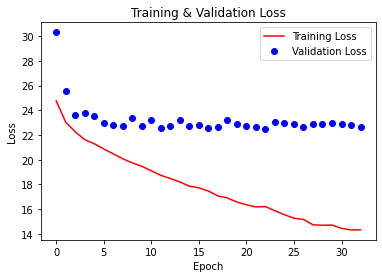

In [22]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(range(len(loss)), loss, 'r', label='Training Loss')
plt.plot(range(len(loss)), val_loss, 'bo', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [23]:
from collections import namedtuple

Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).
                    # Do not modify these IDs, since exactly these IDs are expected by the
                    # evaluation server.

    'trainId'     , # Feel free to modify these IDs as suitable for your method. Then create
                    # ground truth images with train IDs, using the tools provided in the
                    # 'preparation' folder. However, make sure to validate or submit results
                    # to our evaluation server using the regular IDs above!
                    # For trainIds, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.
                    # Max value is 255!

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for your approach.
# Note that you might want to ignore labels with ID 255 during training.
# Further note that the current train IDs are only a suggestion. You can use whatever you like.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]
id2color = { label.id : np.asarray(label.color) for label in labels }


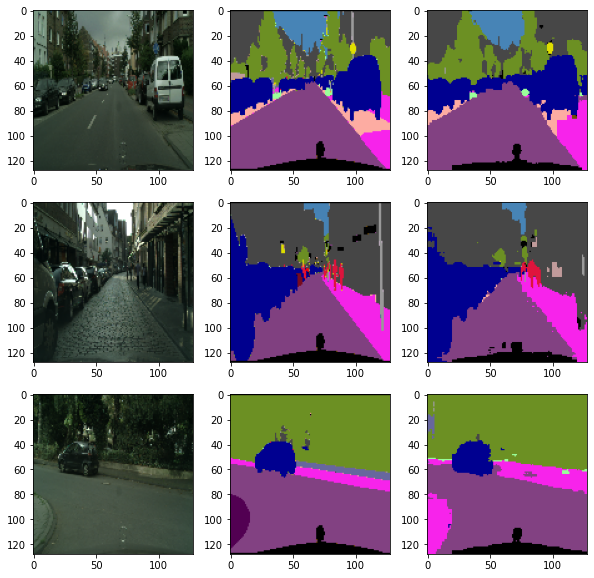

In [24]:
num = 3

for img, label in val_ds.take(1):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1).numpy()
    label=label.numpy()
    tmp = np.zeros([16,pred_label.shape[1], pred_label.shape[2], 3])
    tmp2 = np.zeros([16,pred_label.shape[1], pred_label.shape[2], 3])
    for i in range(3):
        for row in range(pred_label.shape[1]):
            for col in range(pred_label.shape[2]):
                tmp[i,row, col, :] = id2color[pred_label[i,row, col]]
                tmp2[i,row, col, :] = id2color[label[i,row, col,0]]
                tmp = tmp.astype('uint8')
                tmp2 = tmp2.astype('uint8')
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp2[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp[i]))

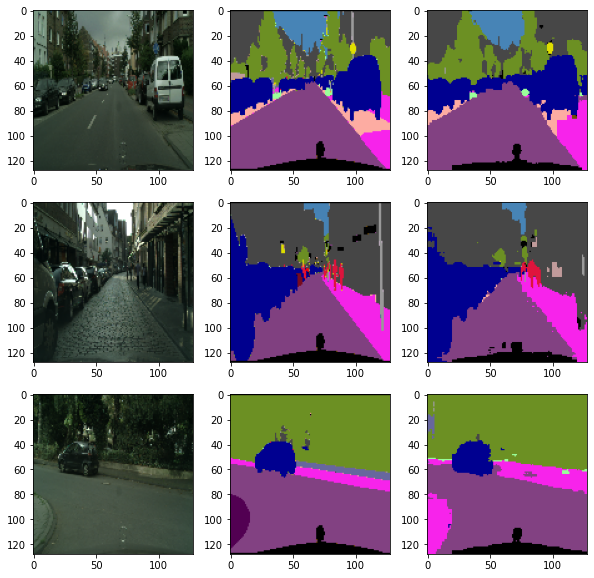

In [27]:
num = 3

for img, label in val_ds.take(1):
    pred_label = model.predict(img)
    pred_label = tf.argmax(pred_label, axis=-1).numpy()
    label=label.numpy()
    tmp = np.zeros([16,pred_label.shape[1], pred_label.shape[2], 3])
    tmp2 = np.zeros([16,pred_label.shape[1], pred_label.shape[2], 3])
    for i in range(3):
        for row in range(pred_label.shape[1]):
            for col in range(pred_label.shape[2]):
                tmp[i,row, col, :] = id2color[pred_label[i,row, col]]
                tmp2[i,row, col, :] = id2color[label[i,row, col,0]]
                tmp = tmp.astype('uint8')
                tmp2 = tmp2.astype('uint8')
    
    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(img[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp2[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(tmp[i]))

In [28]:
model.save('Hr_Net.h5')

<a href="./myunet1.h5"> Download File </a>

<a href="./MyUNet.h5"> Download File 2</a>

